In [1]:
# === 1. Import Library ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# === 2. Load Dataset ===
df = pd.read_csv("WineQT.csv")
# Drop kolom yang tidak diperlukan
df = df.drop(['Id'], axis=1)
df['quality_label'] = df['quality'].apply(lambda x: 1 if x >= 6 else 0)

X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
# === 3. Preprocessing (Yeo-Johnson Transform + Scaling) ===
skewed = ['residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','sulphates']
others = ['fixed acidity','volatile acidity','citric acid','density','pH','alcohol']

preprocessor = ColumnTransformer([
    ('power', PowerTransformer(method='yeo-johnson'), skewed),
    ('scale', StandardScaler(), others + skewed),
], remainder='drop')

In [4]:
# === 4. Cross-validation Setup ===
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)


In [5]:
# === 5. Definisikan parameter grid untuk tuning ===
param_grid = {
    'clf__C': [0.5, 1, 2],
    'clf__gamma': [0.05, 0.1, 0.2],
    'clf__kernel': ['linear', 'poly', 'rbf']
}

In [6]:
# === 6. Pipeline: Preprocessing + SVM ===
pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', SVC(class_weight='balanced'))
])

In [7]:
# === 7. GridSearchCV ===
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    verbose=2,
    n_jobs=-1,
    scoring='f1'
)
grid.fit(X_train, y_train)

print("=== Best Model Parameters ===")
print(grid.best_params_)
print("Best Cross-Validation F1-Score:", grid.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
=== Best Model Parameters ===
{'clf__C': 1, 'clf__gamma': 0.2, 'clf__kernel': 'rbf'}
Best Cross-Validation F1-Score: 0.7694736406555689


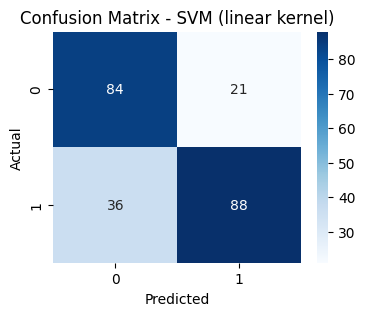

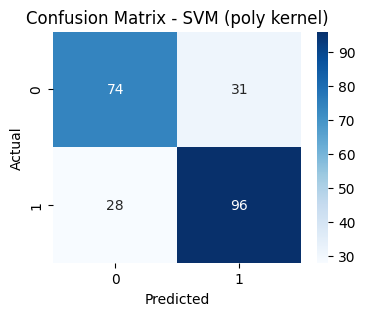

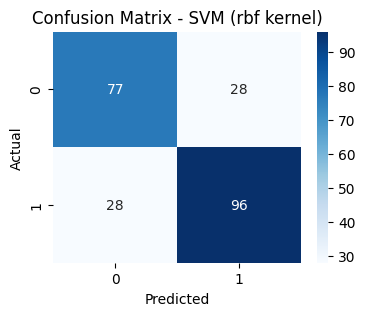

In [8]:
# === 8. Evaluasi Semua Kernel untuk Perbandingan ===
results = []

for kernel in ['linear', 'poly', 'rbf']:
    model = Pipeline([
        ('prep', preprocessor),
        ('clf', SVC(kernel=kernel, C=grid.best_params_['clf__C'], 
                    gamma=grid.best_params_['clf__gamma'], 
                    class_weight='balanced'))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Kernel': kernel,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - SVM ({kernel} kernel)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [9]:
# === 9. Tabel Perbandingan ===
df_results = pd.DataFrame(results)
print("\n=== Perbandingan Hasil Tiap Kernel ===")
print(df_results.round(4))


=== Perbandingan Hasil Tiap Kernel ===
   Kernel  Accuracy  Precision  Recall  F1-Score
0  linear    0.7511     0.8073  0.7097    0.7554
1    poly    0.7424     0.7559  0.7742    0.7649
2     rbf    0.7555     0.7742  0.7742    0.7742


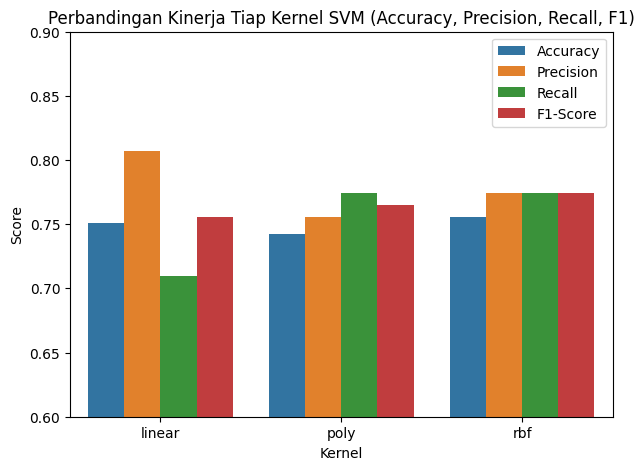

In [10]:
# === 10. Visualisasi Perbandingan ===
plt.figure(figsize=(7,5))
sns.barplot(data=df_results.melt(id_vars='Kernel'), x='Kernel', y='value', hue='variable')
plt.title("Perbandingan Kinerja Tiap Kernel SVM (Accuracy, Precision, Recall, F1)")
plt.ylabel("Score")
plt.ylim(0.6, 0.9)
plt.legend(title="")
plt.show()